In [806]:
import pandas as pd
import numpy as np  
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
import scipy.stats

In [807]:
df = pd.read_excel('final_0826.xlsx', encoding='euc-kr') 
#df.info()
print(len(df))

3630


In [808]:
#다음해 연봉 정보 없는 행 확인, 삭제
print(df['next_year_salary'].isna().sum(axis=0)) #1340행
df2 = df.dropna(subset=['next_year_salary'], axis=0)
#df2.info()
#올해 연봉 정보 없는 행 확인, 삭제
print(df2['this_year_salary'].isna().sum(axis=0))  #250행
df3 = df2.dropna(subset=['this_year_salary'], axis=0)

# 2루타, 3루타 - 세부지표로 2014년 이후 측정 
# -> 총 2290 데이터 중 1076개가 NULL -> 열삭제
print(df3[['B2','B3']].isna().sum(axis=0)) 
df3 = df3.drop(columns=['B2','B3'])
#df3.info()

################################2020년 자료 삭제 (이후 연봉 예측에 사용할 거)###########################################
ind_2020 = df3.iloc[df3.PLAY_YEAR.values == 2020].index #191행
df3.drop(index=ind_2020, axis=0, inplace=True)
#df3.info()
print(len(df3))

1340
249
B2    1076
B3    1076
dtype: int64
1850


그 외 결측치 존재 
: ERA, FIP, WHIP, ERA+, FIP+
: 아웃 하나도 못잡았기 때문에 분모가 없어서 NA 값으로 나타남 
-> 높을수록 안좋은 수치이므로 최대값으로 지정

In [809]:
df3[df3['ERA'].isna() == True]

,PLAYER_ID,PLAY_YEAR,TEAM_NAME,AGE,GP,CG,SO,GS,W,L,...,BK,WP,ERA,FIP,WHIP,ERA_PLUS,FIP_PLUS,WAR,this_year_salary,next_year_salary
242,61457,2014,삼성,26,1,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,3300.0,3300.0
502,63628,2018,KIA,29,2,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,2800.0,2800.0
1006,68249,2019,두산,20,2,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,2700.0,3100.0
1135,70142,2014,한화,33,1,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,8000.0,10000.0
1943,74817,2005,SK,24,1,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,2000.0,2000.0
1950,74838,2009,SK,24,1,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,2000.0,2400.0
2434,76759,2008,한화,21,1,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,2100.0,2100.0
2736,78823,2014,KIA,29,1,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,2800.0,3200.0
3196,95159,2000,LG,23,1,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,1800.0,2000.0


In [810]:
maxs = df3[['ERA', 'FIP', 'WHIP','ERA_PLUS','FIP_PLUS']].max().astype(int)
print(maxs)
# df2[['ERA', 'FIP', 'WHIP','ERA_PLUS','FIP_PLUS']].fillna(maxs, inplace=True)
df3[['ERA', 'FIP', 'WHIP','ERA_PLUS','FIP_PLUS']] = \
df3[['ERA', 'FIP', 'WHIP','ERA_PLUS','FIP_PLUS']].fillna(maxs)

ERA           81
FIP           24
WHIP          12
ERA_PLUS    1116
FIP_PLUS     640
dtype: int32


In [811]:
#연봉변화율 사용하기 위해 추가
df3['salary_diff_pct'] = float()
df3['salary_diff_pct'] = df3['next_year_salary']/df3['this_year_salary']
#df3.head(20)

In [812]:
#df3.info()
#분모 0이면 inf / 또는 분모분자없어 NA 값인 것 조정
df3.fillna(0.0, inplace=True)
df3[df3['salary_diff_pct'] == np.inf ]
mask = df3['salary_diff_pct'] != np.inf
df3.loc[~mask, 'salary_diff_pct'] = df3.loc[mask, 'salary_diff_pct'].max()

In [813]:
# # 연봉 증감율 0.0 인 선수 제거 (FA 포함 동결 선수들)
# #df3.iloc[df3.salary_diff_pct.values == 1.0]
# same = df3.iloc[df3.salary_diff_pct.values == 1.0].index
# print(same)
# df3.drop(index=same, axis=0, inplace=True)
# df3.info()

### 상관계수확인

In [814]:
corr_df = df3.corr()
# corr_df

In [815]:
def corrs(x) :
    if abs(x) >= 0.3 :
        return 'Yes'
    else :
        return 'No'

df4 = corr_df.applymap(lambda x : corrs(x))
df4['next_year_salary'][df4['next_year_salary']=='Yes'] # 상관관계를 갖는 항목 확인

AGE                 Yes
GS                  Yes
W                   Yes
L                   Yes
IP                  Yes
R                   Yes
ER                  Yes
BF                  Yes
H                   Yes
K                   Yes
WAR                 Yes
this_year_salary    Yes
next_year_salary    Yes
Name: next_year_salary, dtype: object

In [816]:
#abs(corr_df['next_year_salary'][3:]).sort_values(ascending=False) #아이디,연도 제외 상관계수 절대값 확인

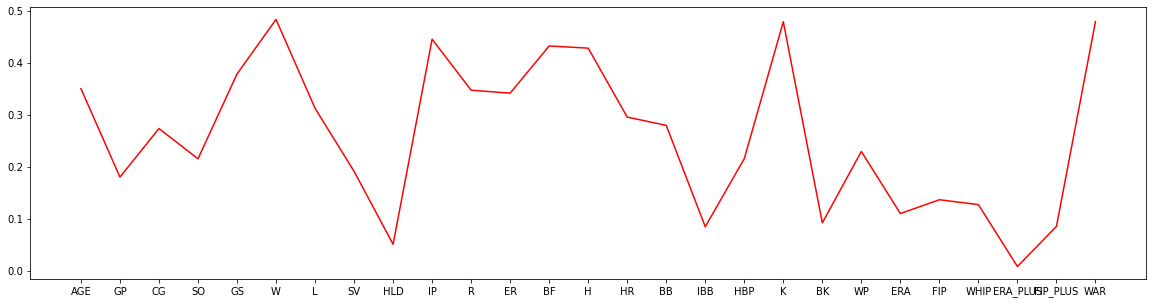

In [817]:
plt.figure(figsize=(20,5))
#sns.heatmap(corr_df, annot=True)
plt.plot(abs(corr_df['next_year_salary'][2:-3]), color='red')
np.array(corr_df['next_year_salary'][2:-3].values)
x = corr_df[3:].columns.values
y = corr_df['next_year_salary'][2:-3].array
#plt.annotate(corr_df['SALARY'][3:].values, (x,y))
plt.show()

In [818]:
# df3['next_year_salary'] = df3['next_year_salary'].astype(int)
#  # 결과값 = 상관계수, p-value
# print(sp.stats.pearsonr(df3['next_year_salary'],df3['AGE']))
# print(sp.stats.pearsonr(df3['next_year_salary'],df3['GP']))
# print(sp.stats.pearsonr(df3['next_year_salary'],df3['W']))
# print(sp.stats.pearsonr(df3['next_year_salary'],df3['IP']))
# print(sp.stats.pearsonr(df3['next_year_salary'],df3['K']))
# print(sp.stats.pearsonr(df3['next_year_salary'],df3['WAR']))

#### 히스토그램, 박스 플롯 등으로 데이터 분포 탐색

In [819]:
# 이상치 값 대체 함수 - d값에 해당 열(Series) 대입
def revalue(d) :
    IQR = d.quantile(0.75)-d.quantile(0.25) #3사분위수 - 1사분위수 (Inter Quartile Range)
    cut_off = IQR*1.5
    lower, upper = (d.quantile(0.25)-cut_off), (d.quantile(0.75)+cut_off)
    # print(lower, upper)
    low_outliers = [x for x in d if x <= lower]
    up_outliers = [y for y in d if y >= upper]

    for x in low_outliers :
        d[d==x] = lower

    for y in up_outliers :
        d[d==y] = upper

    return d

In [820]:
# 25~75% 값 대체 함수 - d값에 해당 열(Series) 대입
def revalue2(d) :
    lower, upper = d.quantile(0.25), d.quantile(0.75)
    # print(lower, upper)
    low_outliers = [x for x in d if x <= lower]
    up_outliers = [y for y in d if y >= upper]

    for x in low_outliers :
        d[d==x] = lower

    for y in up_outliers :
        d[d==y] = upper

    return d

features :
'AGE', 'GP', 'CG', 'SO', 'GS', 'W', 'L', 'SV', 'HLD', 
'IP', 'R', 'ER', 'BF', 'H', 'HR', 'BB', 'IBB', 'HBP',
'K', 'BK', 'WP', 'ERA', 'FIP', 'WHIP', 'ERA_PLUS', 'FIP_PLUS', 'WAR',
'this_year_salary', 'salary_diff_pct', 'salary_vs_avg'

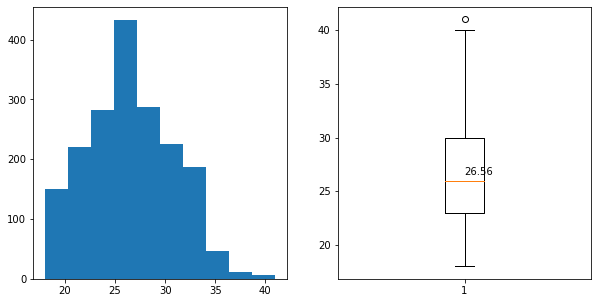

count    1850.000000
mean       26.562162
std         4.294295
min        18.000000
25%        23.000000
50%        26.000000
75%        30.000000
max        41.000000
Name: AGE, dtype: float64
min:18, max:41
count    1850.000000
mean       26.561892
std         4.293401
min        18.000000
25%        23.000000
50%        26.000000
75%        30.000000
max        40.500000
Name: AGE, dtype: float64


In [821]:
# 1. 나이(AGE)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['AGE'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['AGE'])
ax2.text(1,df3['AGE'].mean(),format(df3['AGE'].mean(),'.2f'))

plt.show()

print(df3['AGE'].describe())
print('min:{0}, max:{1}'.format(df3['AGE'].min(),df3['AGE'].max()))

df3['AGE'] = revalue(df3['AGE']) #아웃라이어 정리
print(df3['AGE'].describe())

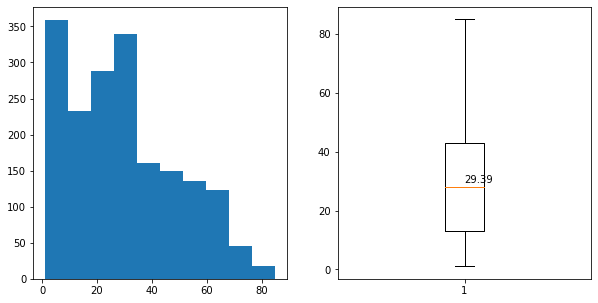

count    1850.000000
mean       29.393514
std        19.838471
min         1.000000
25%        13.000000
50%        28.000000
75%        43.000000
max        85.000000
Name: GP, dtype: float64
min:1, max:85


In [822]:
# 2. 출장경기수(GP)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['GP'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['GP'])
ax2.text(1,df3['GP'].mean(),format(df3['GP'].mean(),'.2f'))

plt.show()

print(df3['GP'].describe())
print('min:{0}, max:{1}'.format(df3['GP'].min(),df3['GP'].max()))
#print(df3['GP'].sort_values(ascending=False))

# df3['GP'] = revalue(df3['GP']) #아웃라이어 없음
# print(df3['GP'].describe())

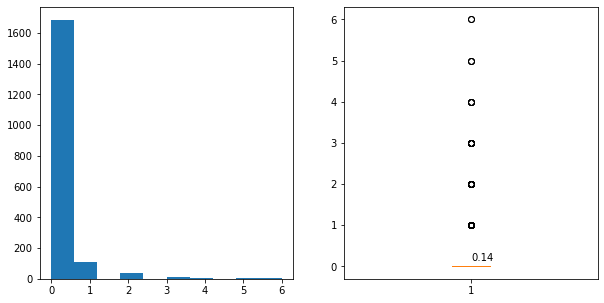

count    1850.000000
mean        0.141081
std         0.541505
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: CG, dtype: float64
min:0, max:6


,PLAYER_ID,PLAY_YEAR,TEAM_NAME,AGE,GP,CG,SO,GS,W,L,...,WP,ERA,FIP,WHIP,ERA_PLUS,FIP_PLUS,WAR,this_year_salary,next_year_salary,salary_diff_pct
54,60263,2014,NC,24.0,29,1,0,28,10,9,...,2,4.21,4.97,1.41,123.6,106.2,3.80,12500.0,20000.0,1.600000
55,60263,2013,NC,23.0,27,2,1,24,10,5,...,2,2.88,3.91,1.17,148.9,110.0,4.44,5000.0,12500.0,2.500000
57,60263,2018,NC,28.0,29,1,0,29,5,13,...,6,4.79,4.54,1.35,108.4,115.4,2.68,19000.0,19000.0,1.000000
182,61240,2014,두산,33.0,30,1,0,28,14,7,...,10,3.81,4.23,1.31,129.7,118.7,5.03,38700.0,120000.0,3.100775
185,61240,2016,두산,35.0,28,1,1,27,22,3,...,8,2.95,4.44,1.24,173.1,113.2,5.97,120000.0,210000.0,1.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,98259,1999,두산,20.0,77,1,1,8,8,4,...,11,4.76,4.77,1.59,101.2,101.1,2.08,2300.0,4000.0,1.739130
3477,98451,2000,삼성,20.0,32,2,1,29,15,7,...,4,4.93,4.56,1.44,96.1,103.9,3.12,5000.0,8000.0,1.600000
3478,98451,1999,삼성,19.0,34,2,0,31,11,13,...,14,5.40,4.89,1.51,93.9,103.7,2.56,3000.0,5000.0,1.666667
3480,98451,2001,삼성,21.0,43,1,1,14,11,7,...,3,3.96,3.87,1.37,121.4,124.2,4.25,8000.0,10000.0,1.250000


In [823]:
# 3. 완투(CG)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['CG'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['CG'])
ax2.text(1,df3['CG'].mean(),format(df3['CG'].mean(),'.2f'))

plt.show()

print(df3['CG'].describe())
print('min:{0}, max:{1}'.format(df3['CG'].min(),df3['CG'].max()))

df3[df3['CG'].values >= 1] #완투 1경기 이상있는 행

완투는 횟수 (범주형) - 완투 횟수는 결국 다른 수치형 항목과 비례할 것이다 (가정) -> 열 자체 feature에서 제외 예정

In [824]:
# print("상관계수, p-value:",sp.stats.pearsonr(df3['CG'],df3['IP']))
# corr_df = df3[['CG','IP', 'SO', 'WAR']].corr()
# corr_df
# plt.figure(figsize=(20,5))
# sns.heatmap(corr_df, annot=True)
# plt.show()

# plt.figure(figsize=(20,15))
# corr_df = df3.corr()

# plt.barh(corr_df['CG'], width=abs(corr_df['CG']).values, height=0.03,  color='green')
# plt.yticks(corr_df['CG'], corr_df.columns, fontsize=10)
# plt.show()

완봉 -> 완투 중 무실점으로 더 좁은 범위 -> 열 자체 feature에서 제외 예정

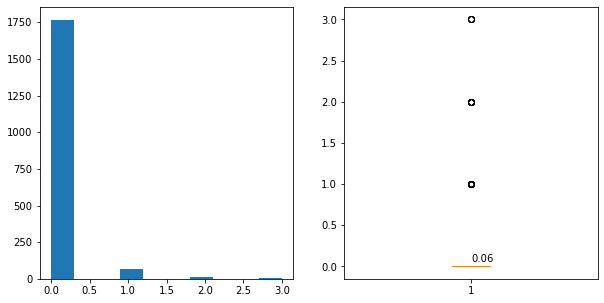

count    1850.000000
mean        0.057297
std         0.286648
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: SO, dtype: float64
min:0, max:3


,PLAYER_ID,PLAY_YEAR,TEAM_NAME,AGE,GP,CG,SO,GS,W,L,...,WP,ERA,FIP,WHIP,ERA_PLUS,FIP_PLUS,WAR,this_year_salary,next_year_salary,salary_diff_pct
55,60263,2013,NC,23.0,27,2,1,24,10,5,...,2,2.88,3.91,1.17,148.9,110.0,4.44,5000.0,12500.0,2.500000
185,61240,2016,두산,35.0,28,1,1,27,22,3,...,8,2.95,4.44,1.24,173.1,113.2,5.97,120000.0,210000.0,1.750000
360,62611,2014,KIA,25.0,29,1,1,24,5,11,...,8,6.06,6.17,1.71,86.1,85.4,1.09,6000.0,6000.0,1.000000
383,62698,2015,LG,30.0,32,2,1,30,10,12,...,6,4.03,3.50,1.21,116.5,134.0,4.23,50000.0,50000.0,1.000000
385,62698,2017,LG,32.0,30,2,1,29,11,11,...,3,3.88,3.52,1.23,124.6,138.3,4.22,50000.0,120000.0,2.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,98259,2005,두산,26.0,30,1,1,21,7,4,...,4,3.95,4.77,1.45,104.7,86.7,1.34,9500.0,12000.0,1.263158
3469,98259,1999,두산,20.0,77,1,1,8,8,4,...,11,4.76,4.77,1.59,101.2,101.1,2.08,2300.0,4000.0,1.739130
3477,98451,2000,삼성,20.0,32,2,1,29,15,7,...,4,4.93,4.56,1.44,96.1,103.9,3.12,5000.0,8000.0,1.600000
3480,98451,2001,삼성,21.0,43,1,1,14,11,7,...,3,3.96,3.87,1.37,121.4,124.2,4.25,8000.0,10000.0,1.250000


In [825]:
# 4. 완봉(SO))
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['SO'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['SO'])
ax2.text(1,df3['SO'].mean(),format(df3['SO'].mean(),'.2f'))

plt.show()

print(df3['SO'].describe())
print('min:{0}, max:{1}'.format(df3['SO'].min(),df3['SO'].max()))

df3[df3['SO'].values >= 1] #완봉 1경기 이상있는 행

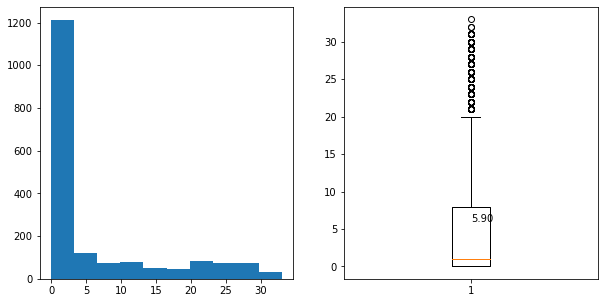

count    1850.000000
mean        5.896216
std         9.130923
min         0.000000
25%         0.000000
50%         1.000000
75%         8.000000
max        33.000000
Name: GS, dtype: float64
min:0, max:33
count    1850.000000
mean        5.122703
std         7.430993
min         0.000000
25%         0.000000
50%         1.000000
75%         8.000000
max        20.000000
Name: GS, dtype: float64


In [826]:
# 5. 선발경기수(GS)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['GS'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['GS'])
ax2.text(1,df3['GS'].mean(),format(df3['GS'].mean(),'.2f'))

plt.show()

print(df3['GS'].describe())
print('min:{0}, max:{1}'.format(df3['GS'].min(),df3['GS'].max()))
#print(df3['GS'].sort_values(ascending=False))

df3['GS'] = revalue(df3['GS']) #아웃라이어 정리
print(df3['GS'].describe())

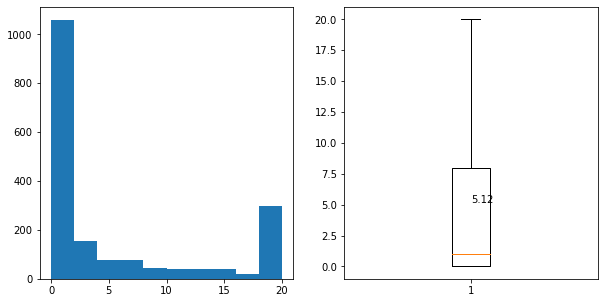

count    1850.000000
mean        5.122703
std         7.430993
min         0.000000
25%         0.000000
50%         1.000000
75%         8.000000
max        20.000000
Name: GS, dtype: float64
min:0, max:20


In [827]:
# 6. 승수(W)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['GS'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['GS'])
ax2.text(1,df3['GS'].mean(),format(df3['GS'].mean(),'.2f'))

plt.show()

print(df3['GS'].describe())
print('min:{0}, max:{1}'.format(df3['GS'].min(),df3['GS'].max()))

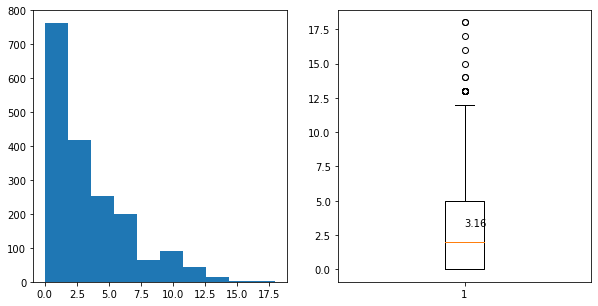

count    1850.000000
mean        3.162162
std         3.250606
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        18.000000
Name: L, dtype: float64
min:0, max:18
count    1850.000000
mean        3.145946
std         3.194615
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        12.500000
Name: L, dtype: float64


In [828]:
# 7. 패(L)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['L'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['L'])
ax2.text(1,df3['L'].mean(),format(df3['L'].mean(),'.2f'))

plt.show()

print(df3['L'].describe())
print('min:{0}, max:{1}'.format(df3['L'].min(),df3['L'].max()))
#print(df3['L'].sort_values(ascending=False))

df3['L'] = revalue(df3['L']) #아웃라이어 정리
print(df3['L'].describe())

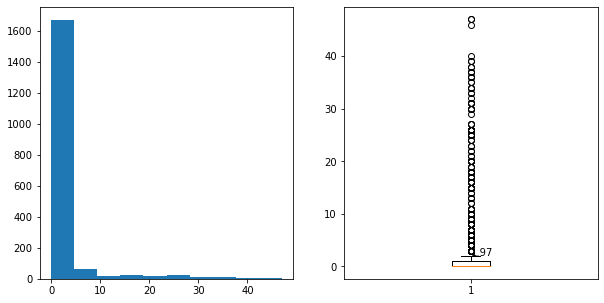

count    1850.000000
mean        1.970270
std         6.055421
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        47.000000
Name: SV, dtype: float64
min:0, max:47
count    1850.000000
mean        0.526486
std         0.908229
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.500000
Name: SV, dtype: float64


In [829]:
# 8. 세이브(SV)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['SV'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['SV'])
ax2.text(1,df3['SV'].mean(),format(df3['SV'].mean(),'.2f'))

plt.show()

print(df3['SV'].describe())
print('min:{0}, max:{1}'.format(df3['SV'].min(),df3['SV'].max()))
# print(df3['SV'].sort_values(ascending=False))

df3['SV'] = revalue(df3['SV']) #아웃라이어 정리
print(df3['SV'].describe())

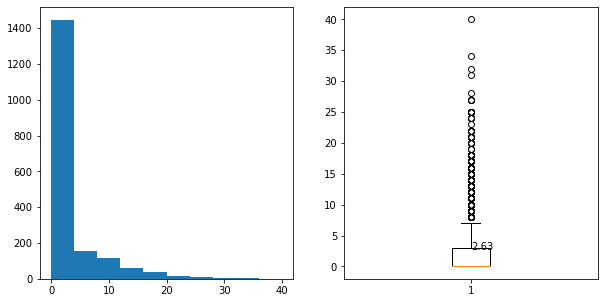

count    1850.000000
mean        2.634595
std         4.942010
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        40.000000
Name: HLD, dtype: float64
min:0, max:40
count    1850.000000
mean        1.838649
std         2.720293
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max         7.500000
Name: HLD, dtype: float64


In [830]:
# 9. 홀드(HLD)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['HLD'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['HLD'])
ax2.text(1,df3['HLD'].mean(),format(df3['HLD'].mean(),'.2f'))

plt.show()

print(df3['HLD'].describe())
print('min:{0}, max:{1}'.format(df3['HLD'].min(),df3['HLD'].max()))

df3['HLD'] = revalue(df3['HLD']) #아웃라이어 정리
print(df3['HLD'].describe())

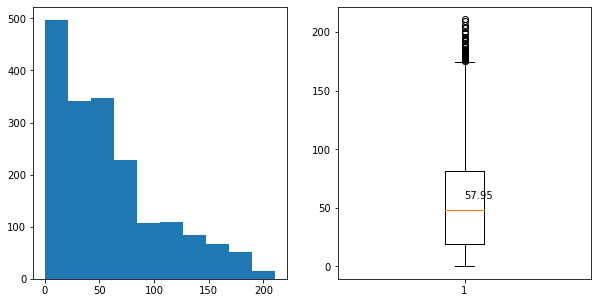

count    1850.000000
mean       57.947784
std        48.369129
min         0.000000
25%        19.000000
50%        48.100000
75%        81.200000
max       211.000000
Name: IP, dtype: float64
min:0.0, max:211.0
count    1850.000000
mean       57.609892
std        47.474416
min         0.000000
25%        19.000000
50%        48.100000
75%        81.200000
max       174.500000
Name: IP, dtype: float64


In [831]:
# 9. 이닝(IP)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['IP'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['IP'])
ax2.text(1,df3['IP'].mean(),format(df3['IP'].mean(),'.2f'))

plt.show()

print(df3['IP'].describe())
print('min:{0}, max:{1}'.format(df3['IP'].min(),df3['IP'].max()))
# print(df3['IP'].sort_values(ascending=False)) # -> 이닝 소화 중 압도적으로 벗어난 1개를 모여있는 최대값으로 동일하게 적용
# df3['IP'] = df3['IP'].replace(427.1,261.2)

df3['IP'] = revalue(df3['IP']) #아웃라이어 정리
print(df3['IP'].describe())

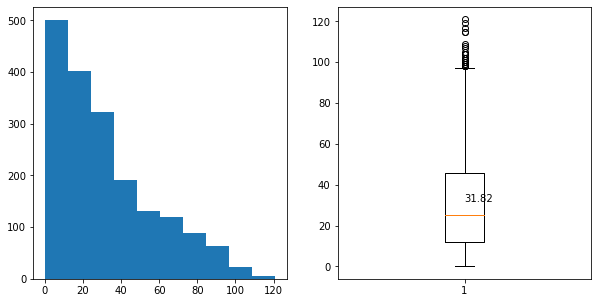

count    1850.000000
mean       31.817297
std        25.561771
min         0.000000
25%        12.000000
50%        25.000000
75%        46.000000
max       121.000000
Name: R, dtype: float64
min:0, max:121
384     121
2320    119
1624    117
344     115
3478    115
       ... 
1194      0
242       0
1868      0
2312      0
2846      0
Name: R, Length: 1850, dtype: int64
count    1850.000000
mean       31.707568
std        25.249569
min         0.000000
25%        12.000000
50%        25.000000
75%        46.000000
max        97.000000
Name: R, dtype: float64


In [832]:
# 10. 실점(R)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['R'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['R'])
ax2.text(1,df3['R'].mean(),format(df3['R'].mean(),'.2f'))

plt.show()

print(df3['R'].describe())
print('min:{0}, max:{1}'.format(df3['R'].min(),df3['R'].max()))

print(df3['R'].sort_values(ascending=False)) 

df3['R'] = revalue(df3['R']) #아웃라이어 정리
print(df3['R'].describe())

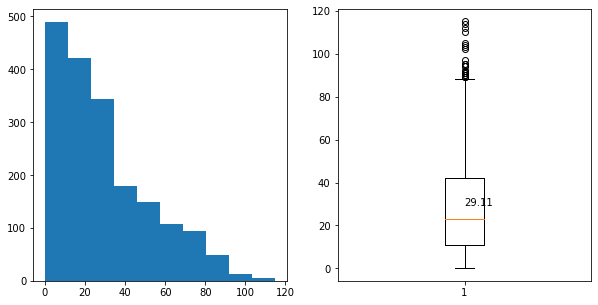

count    1850.000000
mean       29.114595
std        23.418613
min         0.000000
25%        11.000000
50%        23.000000
75%        42.000000
max       115.000000
Name: ER, dtype: float64
min:0, max:115
2320    115
384     114
344     112
1624    110
2774    105
       ... 
2038      0
2898      0
2846      0
2152      0
1194      0
Name: ER, Length: 1850, dtype: int64
count    1850.000000
mean       28.995135
std        23.071156
min         0.000000
25%        11.000000
50%        23.000000
75%        42.000000
max        88.500000
Name: ER, dtype: float64


In [833]:
# 11. 자책점(ER)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['ER'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['ER'])
ax2.text(1,df3['ER'].mean(),format(df3['ER'].mean(),'.2f'))

plt.show()

print(df3['ER'].describe())
print('min:{0}, max:{1}'.format(df3['ER'].min(),df3['ER'].max()))

print(df3['ER'].sort_values(ascending=False)) 

df3['ER'] = revalue(df3['ER']) #아웃라이어 정리
print(df3['ER'].describe())

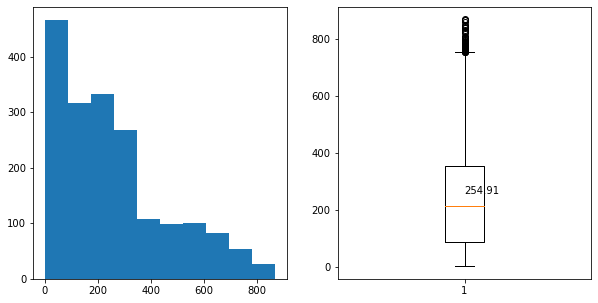

count    1850.000000
mean      254.910270
std       206.872518
min         1.000000
25%        86.250000
50%       212.500000
75%       354.000000
max       870.000000
Name: BF, dtype: float64
min:1, max:870
384     870
884     868
2405    867
761     861
2562    850
       ... 
2908      2
2736      2
1943      2
1950      1
2434      1
Name: BF, Length: 1850, dtype: int64


In [834]:
# 11. 타자수(BF)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['BF'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['BF'])
ax2.text(1,df3['BF'].mean(),format(df3['BF'].mean(),'.2f'))

plt.show()

print(df3['BF'].describe())
print('min:{0}, max:{1}'.format(df3['BF'].min(),df3['BF'].max()))

print(df3['BF'].sort_values(ascending=False)) # ->상대타자수 압도적으로 벗어난 1개를 모여있는 최대값으로 동일하게 적용
df3['BF'] = df3['BF'].replace(1712,1117)

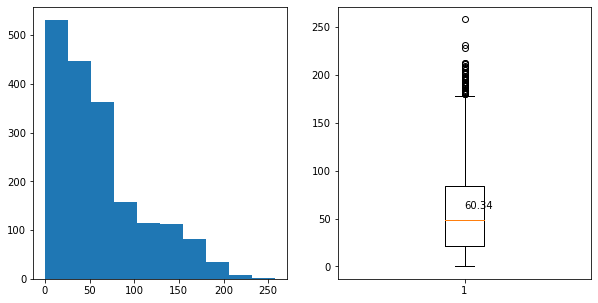

count    1850.000000
mean       60.338378
std        49.571218
min         0.000000
25%        21.000000
50%        49.000000
75%        84.000000
max       258.000000
Name: H, dtype: float64
min:0, max:258
count    1850.000000
mean       59.892973
std        48.354700
min         0.000000
25%        21.000000
50%        49.000000
75%        84.000000
max       178.500000
Name: H, dtype: float64


In [835]:
# 12. 피안타(H)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['H'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['H'])
ax2.text(1,df3['H'].mean(),format(df3['H'].mean(),'.2f'))

plt.show()

print(df3['H'].describe())
print('min:{0}, max:{1}'.format(df3['H'].min(),df3['H'].max()))
#print(df3['H'].sort_values(ascending=False)) 

df3['H'] = revalue(df3['H']) #아웃라이어 정리
print(df3['H'].describe())

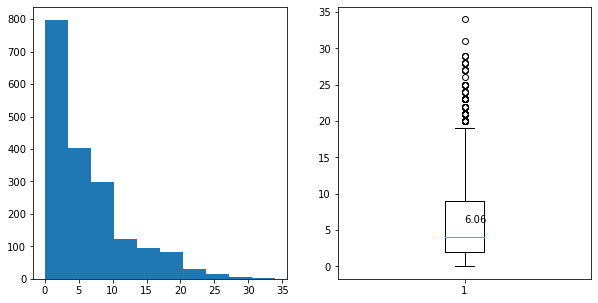

count    1850.000000
mean        6.058378
std         5.844001
min         0.000000
25%         2.000000
50%         4.000000
75%         9.000000
max        34.000000
Name: HR, dtype: float64
min:0, max:34
count    1850.000000
mean        5.922162
std         5.439812
min         0.000000
25%         2.000000
50%         4.000000
75%         9.000000
max        19.500000
Name: HR, dtype: float64


In [836]:
# 13. 피홈런(HR)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['HR'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['HR'])
ax2.text(1,df3['HR'].mean(),format(df3['HR'].mean(),'.2f'))

plt.show()

print(df3['HR'].describe())
print('min:{0}, max:{1}'.format(df3['HR'].min(),df3['HR'].max()))
#print(df3['HR'].sort_values(ascending=False)) 

df3['HR'] = revalue(df3['HR']) #아웃라이어 정리
print(df3['HR'].describe())

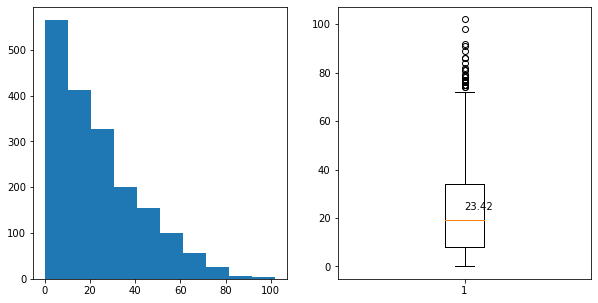

count    1850.000000
mean       23.416216
std        18.889985
min         0.000000
25%         8.000000
50%        19.000000
75%        34.000000
max       102.000000
Name: BB, dtype: float64
min:0, max:102
count    1850.000000
mean       23.284865
std        18.491442
min         0.000000
25%         8.000000
50%        19.000000
75%        34.000000
max        73.000000
Name: BB, dtype: float64


In [837]:
# 14. 볼넷(BB)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['BB'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['BB'])
ax2.text(1,df3['BB'].mean(),format(df3['BB'].mean(),'.2f'))

plt.show()

print(df3['BB'].describe())
print('min:{0}, max:{1}'.format(df3['BB'].min(),df3['BB'].max()))
#print(df3['BB'].sort_values(ascending=False)) 

df3['BB'] = revalue(df3['BB']) #아웃라이어 정리
print(df3['BB'].describe())

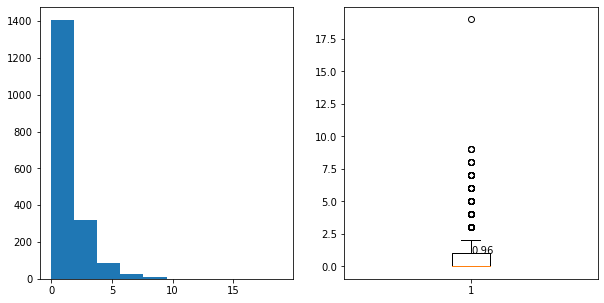

count    1850.000000
mean        0.959459
std         1.539099
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        19.000000
Name: IBB, dtype: float64
min:0, max:19


In [838]:
# 15. 고의사구(IBB)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['IBB'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['IBB'])
ax2.text(1,df3['IBB'].mean(),format(df3['IBB'].mean(),'.2f'))

plt.show()

print(df3['IBB'].describe())
print('min:{0}, max:{1}'.format(df3['IBB'].min(),df3['IBB'].max()))

고의사구는 투수 역량과 무관 -> 열 자체 feature에서 제외 예정

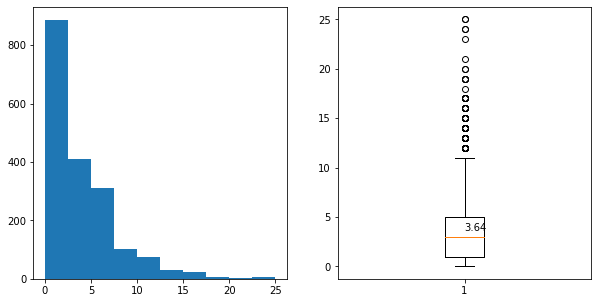

count    1850.000000
mean        3.643784
std         3.722111
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        25.000000
Name: HBP, dtype: float64
min:0, max:25
count    1850.0000
mean        3.4600
std         3.1499
min         0.0000
25%         1.0000
50%         3.0000
75%         5.0000
max        11.0000
Name: HBP, dtype: float64


In [839]:
# 16. 몸맞는공(HBP)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['HBP'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['HBP'])
ax2.text(1,df3['HBP'].mean(),format(df3['HBP'].mean(),'.2f'))

plt.show()

print(df3['HBP'].describe())
print('min:{0}, max:{1}'.format(df3['HBP'].min(),df3['HBP'].max()))

df3['HBP'] = revalue(df3['HBP']) #아웃라이어 정리
print(df3['HBP'].describe())

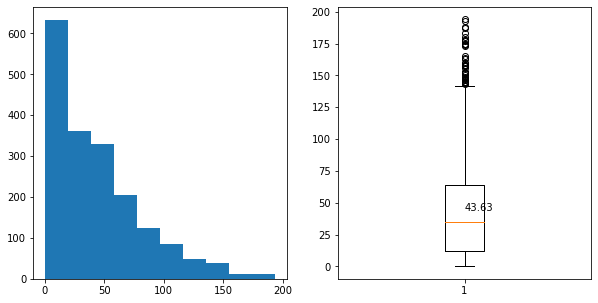

count    1850.000000
mean       43.629189
std        38.524922
min         0.000000
25%        12.000000
50%        35.000000
75%        64.000000
max       194.000000
Name: K, dtype: float64
min:0, max:194
2323    194
318     193
2407    188
2408    187
2600    183
       ... 
1569      0
1182      0
2517      0
1194      0
2115      0
Name: K, Length: 1850, dtype: int64


In [840]:
# 17. 탈삼진(K)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['K'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['K'])
ax2.text(1,df3['K'].mean(),format(df3['K'].mean(),'.2f'))

plt.show()

print(df3['K'].describe())
print('min:{0}, max:{1}'.format(df3['K'].min(),df3['K'].max()))
print(df3['K'].sort_values(ascending=False))

# df3['K'] = revalue(df3['K']) #아웃라이어 정리
# print(df3['K'].describe())

삼진 - 연봉산정에 가장 큰 요소 중 하나로 추정, outlier 정리하지 않음

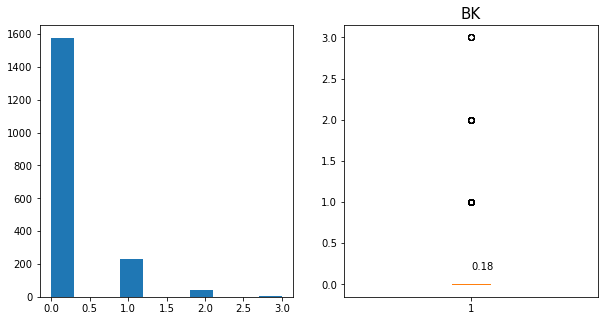

count    1850.000000
mean        0.175135
std         0.454088
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: BK, dtype: float64
min:0, max:3
보크1개이상:273, 보크5개이상:0


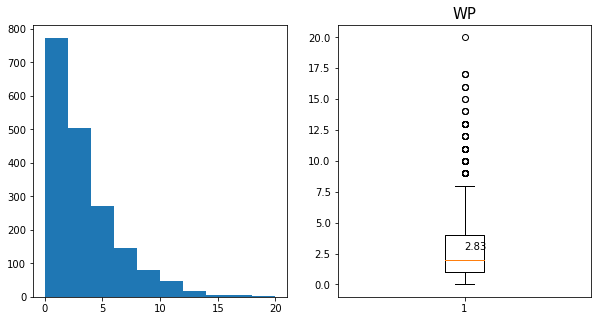

count    1850.000000
mean        2.831892
std         2.960596
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        20.000000
Name: WP, dtype: float64
min:0, max:20
폭투1개이상:1415, 폭투5개이상:416


In [841]:
# 18. 보크(BK)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['BK'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['BK'])
ax2.text(1,df3['BK'].mean(),format(df3['BK'].mean(),'.2f'))

plt.title(label='BK', fontdict={'fontsize':15})
plt.show()

print(df3['BK'].describe())
print('min:{0}, max:{1}'.format(df3['BK'].min(),df3['BK'].max()))
print ("보크1개이상:{0}, 보크5개이상:{1}".format(len(df3[df3['BK'].values >= 1]),len(df3[df3['BK'].values >= 5])))

# 19. 폭투(WP)
plt.figure(figsize=(10,5))
plt.title('WP')

ax1 = plt.subplot(121)
ax1.hist(df3['WP'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['WP'])
ax2.text(1,df3['WP'].mean(),format(df3['WP'].mean(),'.2f'))

plt.title(label='WP', fontdict={'fontsize':15})
plt.show()

print(df3['WP'].describe())
print('min:{0}, max:{1}'.format(df3['WP'].min(),df3['WP'].max()))
print ("폭투1개이상:{0}, 폭투5개이상:{1}".format(len(df3[df3['WP'].values >= 1]),len(df3[df3['WP'].values >= 5])))

보크, 폭투 열 자체 feature에서 제외 예정

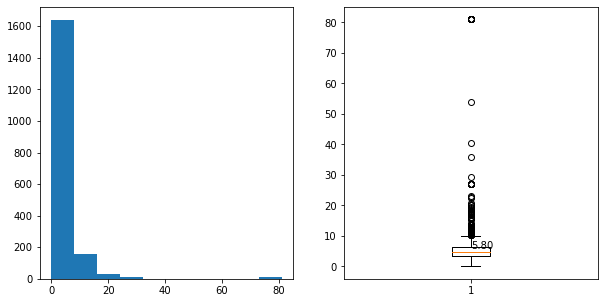

count    1850.000000
mean        5.797914
std         6.638427
min         0.000000
25%         3.580000
50%         4.735000
75%         6.230000
max        81.000000
Name: ERA, dtype: float64
min:0.0, max:81.0
1135    81.0
1006    81.0
242     81.0
2736    81.0
3196    81.0
        ... 
1000     0.0
487      0.0
949      0.0
948      0.0
626      0.0
Name: ERA, Length: 1850, dtype: float64
count    1850.000000
mean        5.070414
std         2.299800
min         0.000000
25%         3.580000
50%         4.735000
75%         6.230000
max        10.205000
Name: ERA, dtype: float64


In [842]:
# 20. 평균자책점(ERA)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['ERA'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['ERA'])
ax2.text(1,df3['ERA'].mean(),format(df3['ERA'].mean(),'.2f'))

plt.show()

print(df3['ERA'].describe())
print('min:{0}, max:{1}'.format(df3['ERA'].min(),df3['ERA'].max()))
print(df3['ERA'].sort_values(ascending=False))

df3['ERA'] = revalue(df3['ERA']) #아웃라이어 정리
print(df3['ERA'].describe())

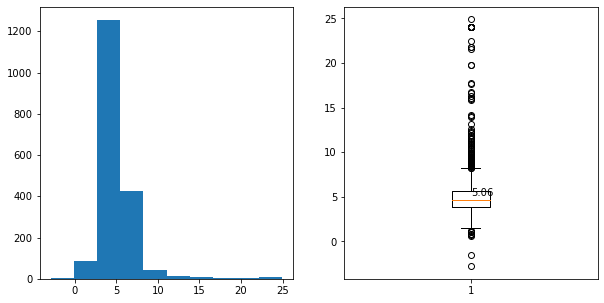

count    1850.000000
mean        5.056865
std         2.439235
min        -2.810000
25%         3.850000
50%         4.690000
75%         5.600000
max        24.900000
Name: FIP, dtype: float64
min:-2.81, max:24.9
2294    24.90
2434    24.00
242     24.00
502     24.00
3196    24.00
        ...  
661      0.79
948      0.74
2093     0.61
1159    -1.50
109     -2.81
Name: FIP, Length: 1850, dtype: float64
count    1850.000000
mean        4.838189
std         1.423584
min         1.225000
25%         3.850000
50%         4.690000
75%         5.600000
max         8.225000
Name: FIP, dtype: float64


In [843]:
# 21. 수비무관 추정 평균자책점(FIP)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['FIP'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['FIP'])
ax2.text(1,df3['FIP'].mean(),format(df3['FIP'].mean(),'.2f'))

plt.show()

print(df3['FIP'].describe())
print('min:{0}, max:{1}'.format(df3['FIP'].min(),df3['FIP'].max()))
print(df3['FIP'].sort_values(ascending=False))

df3['FIP'] = revalue(df3['FIP']) #아웃라이어 정리
print(df3['FIP'].describe())

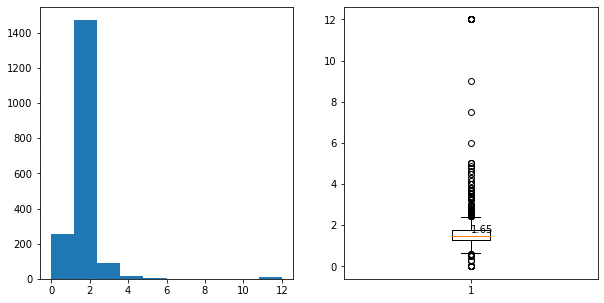

count    1850.000000
mean        1.651422
std         0.949743
min         0.000000
25%         1.300000
50%         1.500000
75%         1.750000
max        12.000000
Name: WHIP, dtype: float64
min:0.0, max:12.0
1135    12.0
1006    12.0
2486    12.0
242     12.0
1943    12.0
        ... 
738      0.0
2357     0.0
109      0.0
3586     0.0
626      0.0
Name: WHIP, Length: 1850, dtype: float64
count    1850.000000
mean        1.556222
std         0.379310
min         0.625000
25%         1.300000
50%         1.500000
75%         1.750000
max         2.425000
Name: WHIP, dtype: float64


In [844]:
# 23. 이닝당출루허용률(WHIP)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['WHIP'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['WHIP'])
ax2.text(1,df3['WHIP'].mean(),format(df3['WHIP'].mean(),'.2f'))

plt.show()

print(df3['WHIP'].describe())
print('min:{0}, max:{1}'.format(df3['WHIP'].min(),df3['WHIP'].max()))
print(df3['WHIP'].sort_values(ascending=False))

df3['WHIP'] = revalue(df3['WHIP']) #아웃라이어 정리
print(df3['WHIP'].describe())

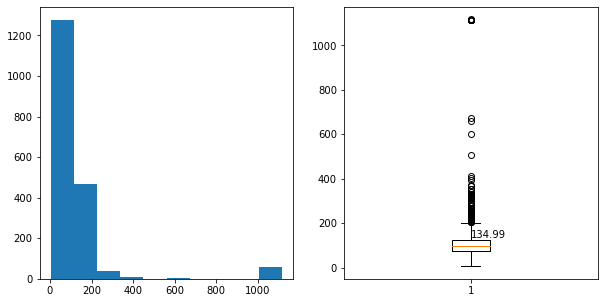

count    1850.000000
mean      134.986649
std       181.714659
min         5.800000
25%        74.000000
50%        97.150000
75%       126.275000
max      1116.700000
Name: ERA_PLUS, dtype: float64
min:5.8, max:1116.7
1349    1116.7
1490    1116.0
1184    1116.0
738     1116.0
741     1116.0
         ...  
3203      15.3
244       14.6
2702       9.5
999        9.4
2486       5.8
Name: ERA_PLUS, Length: 1850, dtype: float64
count    1850.000000
mean      104.099872
std        44.366681
min         5.800000
25%        74.000000
50%        97.150000
75%       126.275000
max       204.687500
Name: ERA_PLUS, dtype: float64


In [845]:
# 23. 파크팩터조정 평균자책점(ERA+)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['ERA_PLUS'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['ERA_PLUS'])
ax2.text(1,df3['ERA_PLUS'].mean(),format(df3['ERA_PLUS'].mean(),'.2f'))

plt.show()

print(df3['ERA_PLUS'].describe())
print('min:{0}, max:{1}'.format(df3['ERA_PLUS'].min(),df3['ERA_PLUS'].max()))
print(df3['ERA_PLUS'].sort_values(ascending=False))

df3['ERA_PLUS'] = revalue(df3['ERA_PLUS']) #아웃라이어 정리
print(df3['ERA_PLUS'].describe())

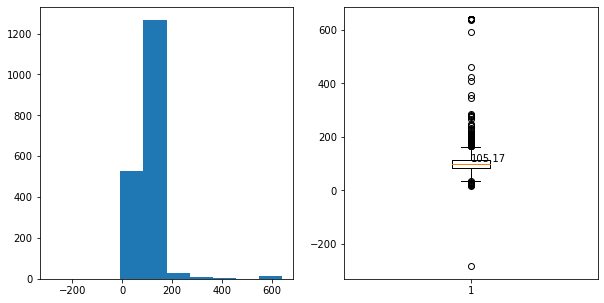

count    1850.000000
mean      105.173027
std        58.411486
min      -285.000000
25%        82.400000
50%        97.700000
75%       115.075000
max       640.000000
Name: FIP_PLUS, dtype: float64
min:-285.0, max:640.0
1006    640.0
1950    640.0
3196    640.0
2434    640.0
242     640.0
        ...  
2486     22.3
1569     20.0
1126     18.4
2294     16.7
1159   -285.0
Name: FIP_PLUS, Length: 1850, dtype: float64
count    1850.000000
mean      100.121473
std        27.415973
min        33.387500
25%        82.400000
50%        97.700000
75%       115.075000
max       164.087500
Name: FIP_PLUS, dtype: float64


In [846]:
# 24. 파크팩터조정 FIP (FIP+)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['FIP_PLUS'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['FIP_PLUS'])
ax2.text(1,df3['FIP_PLUS'].mean(),format(df3['FIP_PLUS'].mean(),'.2f'))

plt.show()

print(df3['FIP_PLUS'].describe())
print('min:{0}, max:{1}'.format(df3['FIP_PLUS'].min(),df3['FIP_PLUS'].max()))
print(df3['FIP_PLUS'].sort_values(ascending=False))

df3['FIP_PLUS'] = revalue(df3['FIP_PLUS']) #아웃라이어 정리
print(df3['FIP_PLUS'].describe())

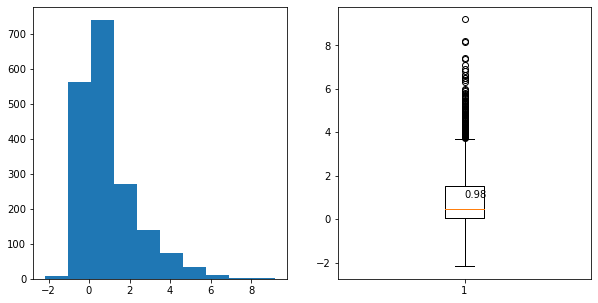

count    1850.000000
mean        0.977038
std         1.398687
min        -2.180000
25%         0.030000
50%         0.480000
75%         1.507500
max         9.200000
Name: WAR, dtype: float64
min:-2.18, max:9.2
2408    9.20
3243    8.22
2563    8.14
3242    7.41
2559    7.37
        ... 
842    -1.18
578    -1.20
799    -1.22
218    -1.32
1842   -2.18
Name: WAR, Length: 1850, dtype: float64
count    1850.000000
mean        0.907909
std         1.191699
min        -2.180000
25%         0.030000
50%         0.480000
75%         1.507500
max         3.723750
Name: WAR, dtype: float64


In [847]:
# 25. 대체선수대비 승리기여도 (WAR)
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['WAR'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['WAR'])
ax2.text(1,df3['WAR'].mean(),format(df3['WAR'].mean(),'.2f'))

plt.show()

print(df3['WAR'].describe())
print('min:{0}, max:{1}'.format(df3['WAR'].min(),df3['WAR'].max()))
print(df3['WAR'].sort_values(ascending=False))

df3['WAR'] = revalue(df3['WAR']) #아웃라이어 정리
print(df3['WAR'].describe())

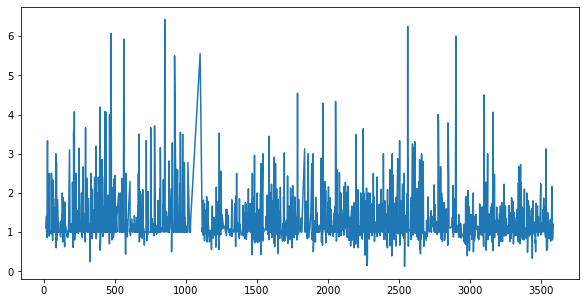

count    1850.000000
mean        1.288953
std         0.619264
min         0.125000
25%         1.000000
50%         1.066667
75%         1.405405
max         6.428571
Name: salary_diff_pct, dtype: float64
min:0.125, max:6.428571428571429
853     6.428571
2564    6.250000
475     6.071429
2904    6.000000
565     5.925926
          ...   
3442    0.333333
2280    0.266667
327     0.250000
2278    0.150000
2542    0.125000
Name: salary_diff_pct, Length: 1850, dtype: float64


In [848]:
# 26. 연봉증감율 (salary_diff_pct)
plt.figure(figsize=(10,5))
plt.plot(df3['salary_diff_pct'])
#plt.xlabel(df3[['PLAYER_ID','PLAY_YEAR']])
plt.show()

print(df3['salary_diff_pct'].describe())
print('min:{0}, max:{1}'.format(df3['salary_diff_pct'].min(),df3['salary_diff_pct'].max()))
print(df3['salary_diff_pct'].sort_values(ascending=False))

# df3['salary_diff_pct'] = revalue(df3['salary_diff_pct']) #아웃라이어 정리하지 말기!!!
# print(df3['salary_diff_pct'].describe())

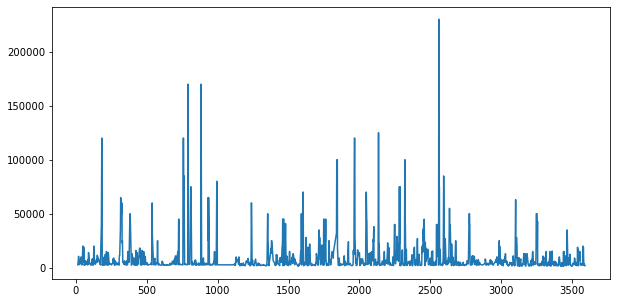

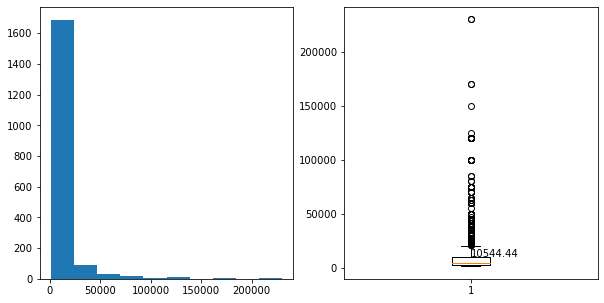

count      1850.000000
mean      10544.435135
std       18146.520282
min        1200.000000
25%        2800.000000
50%        4700.000000
75%       10000.000000
max      230000.000000
Name: this_year_salary, dtype: float64
min:1200.0, max:230000.0
2560    230000.0
2559    230000.0
884     170000.0
792     170000.0
2561    150000.0
          ...   
3419      1500.0
3347      1500.0
3125      1300.0
3435      1200.0
3420      1200.0
Name: this_year_salary, Length: 1850, dtype: float64


In [849]:
# 27. 올해연봉 (this_year_salary)
plt.figure(figsize=(10,5))
plt.plot(df3['this_year_salary'])
#plt.xlabel(df3[['PLAYER_ID','PLAY_YEAR']])
plt.show()

plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['this_year_salary'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['this_year_salary'])
ax2.text(1,df3['this_year_salary'].mean(),format(df3['this_year_salary'].mean(),'.2f'))

plt.show()

print(df3['this_year_salary'].describe())
print('min:{0}, max:{1}'.format(df3['this_year_salary'].min(),df3['this_year_salary'].max()))
print(df3['this_year_salary'].sort_values(ascending=False))

# df3['this_year_salary'] = revalue2(df3['this_year_salary']) #25~75% 외 정리
# print(df3['this_year_salary'].describe())

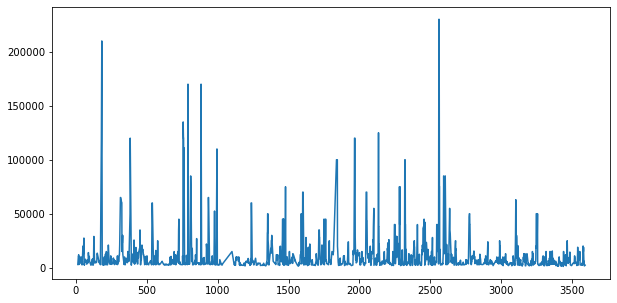

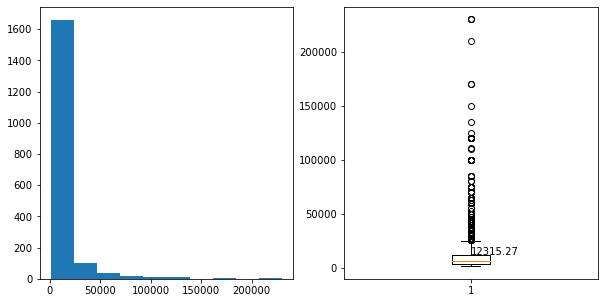

count      1850.000000
mean      12315.267568
std       20399.777704
min        1200.000000
25%        3300.000000
50%        6000.000000
75%       12000.000000
max      230000.000000
Name: next_year_salary, dtype: float64
min:1200.0, max:230000.0
2559    230000.0
2560    230000.0
2561    230000.0
185     210000.0
792     170000.0
          ...   
1340      1700.0
3400      1600.0
3146      1500.0
3420      1500.0
3435      1200.0
Name: next_year_salary, Length: 1850, dtype: float64


In [850]:
# 내년 연봉 (next_year_salary)
plt.figure(figsize=(10,5))
plt.plot(df3['next_year_salary'])
#plt.xlabel(df3[['PLAYER_ID','PLAY_YEAR']])
plt.show()

plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['next_year_salary'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['next_year_salary'])
ax2.text(1,df3['next_year_salary'].mean(),format(df3['next_year_salary'].mean(),'.2f'))

plt.show()

print(df3['next_year_salary'].describe())
print('min:{0}, max:{1}'.format(df3['next_year_salary'].min(),df3['next_year_salary'].max()))
print(df3['next_year_salary'].sort_values(ascending=False))

# df3['next_year_salary'] = revalue2(df3['next_year_salary']) #25~75% 외 정리
# print(df3['next_year_salary'].describe())

In [851]:
# 연도 별 평균 연봉 삽입
df3['this_year_salary_mean'] = df3.apply(lambda val : df3[df3["PLAY_YEAR"] == val['PLAY_YEAR']]["this_year_salary"].mean(), axis=1)
df3

,PLAYER_ID,PLAY_YEAR,TEAM_NAME,AGE,GP,CG,SO,GS,W,L,...,ERA,FIP,WHIP,ERA_PLUS,FIP_PLUS,WAR,this_year_salary,next_year_salary,salary_diff_pct,this_year_salary_mean
16,60105,2016,LG,25.0,2,0,0,0,0,0.0,...,6.35,8.225,1.060,80.1000,43.7,0.05,2700.0,3000.0,1.111111,18031.386861
20,60140,2017,LG,30.0,63,0,0,0,3,5.0,...,5.34,4.230,1.440,90.6000,115.0,-0.22,7500.0,10500.0,1.400000,16678.625954
21,60140,2018,LG,31.0,49,0,0,1,3,7.0,...,5.86,4.270,1.500,86.1000,117.5,0.02,10500.0,10500.0,1.000000,14608.823529
22,60140,2019,"LG,한화",32.0,44,0,0,1,5,1.0,...,5.84,5.400,1.550,70.6000,76.0,-0.57,10500.0,12000.0,1.142857,14191.406250
24,60140,2012,LG,25.0,1,0,0,0,0,0.0,...,0.00,3.100,1.500,204.6875,123.1,-0.01,3500.0,3000.0,0.857143,9911.764706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,99563,2009,롯데,29.0,8,0,0,0,0,0.0,...,9.45,6.790,1.730,50.7000,70.6,-0.18,3500.0,3500.0,1.000000,7611.764706
3582,99563,2010,롯데,30.0,52,0,0,0,1,4.0,...,3.75,4.170,1.460,123.5000,110.9,1.27,3500.0,6000.0,1.714286,7969.342105
3584,99719,2000,한화,24.0,2,0,0,0,0,0.0,...,10.13,8.225,2.425,47.0000,49.9,-0.05,2100.0,1700.0,0.809524,4078.181818
3586,99738,1999,한화,23.0,1,0,0,0,0,0.0,...,0.00,3.270,0.625,204.6875,155.9,0.04,2000.0,2000.0,1.000000,3671.698113


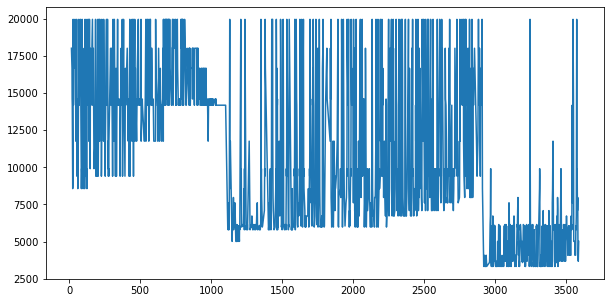

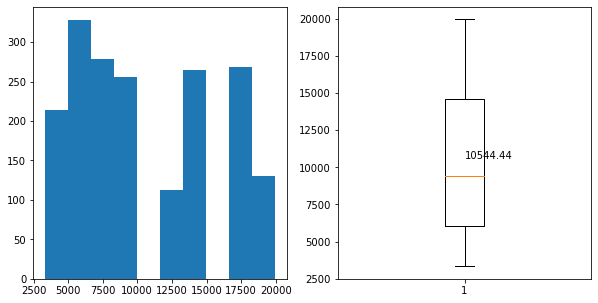

count     1850.000000
mean     10544.435135
std       5151.409021
min       3320.185185
25%       6061.702128
50%       9405.555556
75%      14608.823529
max      19979.230769
Name: this_year_salary_mean, dtype: float64
min:3320.185185185185, max:19979.23076923077


In [852]:
# 28. 시즌평균연봉 (this_year_salary_mean)
plt.figure(figsize=(10,5))
plt.plot(df3['this_year_salary_mean'])
#plt.xlabel(df3[['PLAYER_ID','PLAY_YEAR']])
plt.show()

plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.hist(df3['this_year_salary_mean'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(df3['this_year_salary_mean'])
ax2.text(1,df3['this_year_salary_mean'].mean(),format(df3['this_year_salary_mean'].mean(),'.2f'))

plt.show()

print(df3['this_year_salary_mean'].describe())
print('min:{0}, max:{1}'.format(df3['this_year_salary_mean'].min(),df3['this_year_salary_mean'].max()))

# df3['this_year_salary_mean'] = revalue2(df3['this_year_salary_mean']) #25~75% 외 정리
# print(df3['this_year_salary_mean'].describe())

In [853]:
#평균대비연봉 사용하기 위해 추가
df3['salary_vs_avg'] = float()
df3['salary_vs_avg'] = df3['this_year_salary']/df3['this_year_salary_mean']
df3.head(20)

,PLAYER_ID,PLAY_YEAR,TEAM_NAME,AGE,GP,CG,SO,GS,W,L,...,FIP,WHIP,ERA_PLUS,FIP_PLUS,WAR,this_year_salary,next_year_salary,salary_diff_pct,this_year_salary_mean,salary_vs_avg
16,60105,2016,LG,25.0,2,0,0,0,0,0.0,...,8.225,1.06,80.1000,43.7,0.05,2700.0,3000.0,1.111111,18031.386861,0.149739
20,60140,2017,LG,30.0,63,0,0,0,3,5.0,...,4.230,1.44,90.6000,115.0,-0.22,7500.0,10500.0,1.400000,16678.625954,0.449677
21,60140,2018,LG,31.0,49,0,0,1,3,7.0,...,4.270,1.50,86.1000,117.5,0.02,10500.0,10500.0,1.000000,14608.823529,0.718744
22,60140,2019,"LG,한화",32.0,44,0,0,1,5,1.0,...,5.400,1.55,70.6000,76.0,-0.57,10500.0,12000.0,1.142857,14191.406250,0.739884
24,60140,2012,LG,25.0,1,0,0,0,0,0.0,...,3.100,1.50,204.6875,123.1,-0.01,3500.0,3000.0,0.857143,9911.764706,0.353116
25,60140,2011,LG,24.0,11,0,0,0,0,0.0,...,2.570,1.13,204.6875,159.6,0.62,3000.0,3500.0,1.166667,8566.666667,0.350195
27,60140,2013,LG,26.0,26,0,0,20,9,5.0,...,3.990,1.29,99.7000,106.5,2.26,3000.0,10000.0,3.333333,9405.555556,0.318960
28,60146,2015,LG,24.0,15,0,0,0,0,0.0,...,3.880,1.57,80.0000,122.7,0.11,3700.0,3700.0,1.000000,19979.230769,0.185192
30,60146,2019,삼성,28.0,34,0,0,0,2,1.0,...,3.400,1.05,204.6875,124.8,1.17,7000.0,10000.0,1.428571,14191.406250,0.493256
31,60146,2018,삼성,27.0,19,0,0,0,1,1.0,...,6.830,1.77,66.8000,77.3,-0.07,7000.0,7000.0,1.000000,14608.823529,0.479162


<Figure size 720x360 with 0 Axes>

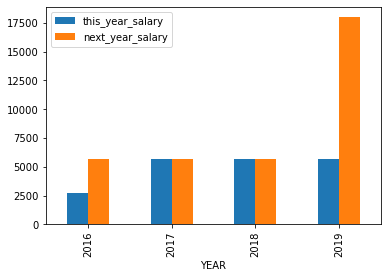

In [854]:
df_koo = df3[df3['PLAYER_ID'] == 65933]
koo = df_koo[['PLAY_YEAR','this_year_salary','next_year_salary']]
koo.set_index('PLAY_YEAR',drop=True, inplace=True)
koo.sort_index(axis=0,inplace=True, ascending=True)
koo

plt.figure(figsize=(10,5))
#plt.plot(df_koo['PLAY_YEAR'],df_koo['salary_diff_pct'])
koo.plot(kind='bar')
plt.xlabel('YEAR')
#plt.ylabel('next_year_salary')
plt.show()

# ML

In [855]:
df4 = df3.drop(['CG', 'SO', 'IBB', 'BK', 'WP','next_year_salary'], axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850 entries, 16 to 3589
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PLAYER_ID              1850 non-null   int64  
 1   PLAY_YEAR              1850 non-null   int64  
 2   TEAM_NAME              1850 non-null   object 
 3   AGE                    1850 non-null   float64
 4   GP                     1850 non-null   int64  
 5   GS                     1850 non-null   int64  
 6   W                      1850 non-null   int64  
 7   L                      1850 non-null   float64
 8   SV                     1850 non-null   float64
 9   HLD                    1850 non-null   float64
 10  IP                     1850 non-null   float64
 11  R                      1850 non-null   int64  
 12  ER                     1850 non-null   float64
 13  BF                     1850 non-null   int64  
 14  H                      1850 non-null   float64
 15  HR 

In [856]:
from sklearn.model_selection import train_test_split
X = df4.iloc[:,3:].values
y = df3['next_year_salary'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

#스케일 조정
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(X_train)
X_train_scaled, X_test_scaled = mms.transform(X_train),mms.transform(X_test)

In [857]:
#KNN Regressor
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_neighbors=5)
knnr.fit(X_train_scaled, y_train)

predicted_y = knnr.predict(X_test_scaled)
predicted_y
print((predicted_y == y_test).sum()) # = 0 (분류처럼 비교하면 정확히 일치하는 값 없다)

print(knnr.score(X_train_scaled, y_train), knnr.score(X_test_scaled, y_test))

1
0.7953866466413999 0.6562348409359249


In [858]:
#선형
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lr = LinearRegression().fit(X_train_scaled, y_train)
print('lr', lr.score(X_train_scaled, y_train), lr.score(X_test_scaled, y_test))

rlr = Ridge().fit(X_train_scaled, y_train)
print('rlr', rlr.score(X_train_scaled, y_train), rlr.score(X_test_scaled, y_test))

llr = Lasso().fit(X_train_scaled, y_train)
print('llr', llr.score(X_train_scaled, y_train), llr.score(X_test_scaled, y_test))

lr 0.9194801821838579 0.921704213456221
rlr 0.9048810680211867 0.8982079659031293
llr 0.9193888670648751 0.921597443158355


0.8949812079628523 0.8848404495974324
[ 8250.05995204 16858.29268293  3883.33848532] [ 4500. 11000.  2800.]


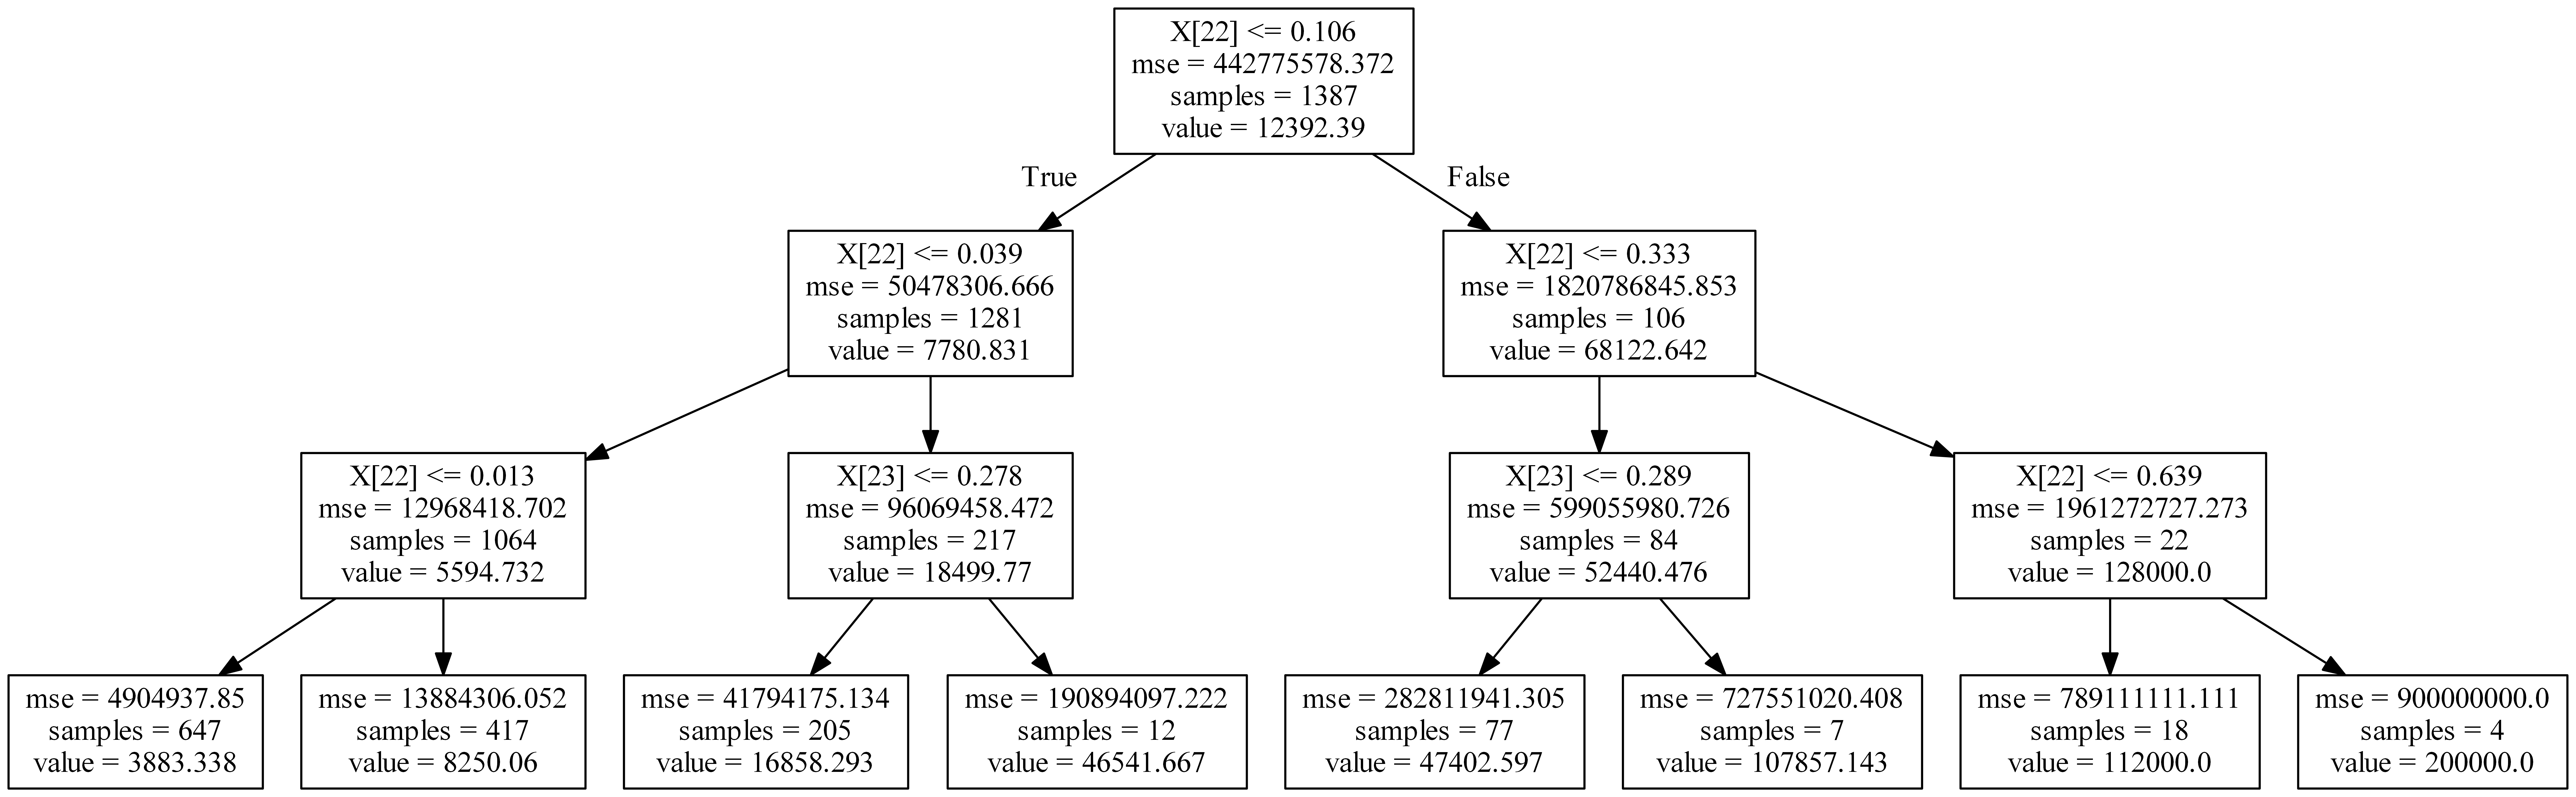

In [859]:
#의사결정트리
from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor(max_depth=3, random_state=0)
DTR.fit(X_train_scaled, y_train)
print(DTR.score(X_train_scaled, y_train), DTR.score(X_test_scaled, y_test))
print(DTR.predict(X_train_scaled[:3]), y_test[:3])


from sklearn.tree import export_graphviz #시각화
import graphviz
export_graphviz(DTR, out_file='tree.dot')
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'decistion-tree.png', '-Gdpi=600'])
from IPython.display import Image
Image(filename = 'decistion-tree.png')


In [860]:
#랜덤포레스트 -> scale 필요X
# 트리 1개
DTR = DecisionTreeRegressor(max_depth=8, random_state=0)
DTR.fit(X_train, y_train)
print(DTR.score(X_train, y_train), DTR.score(X_test, y_test))

# 트리 n개
from sklearn.ensemble import RandomForestRegressor
for d in range(1,10) : #n_estimators default = 100
    RFR = RandomForestRegressor(random_state=0, max_depth=d) 
    RFR.fit(X_train, y_train)
    print("max_depth:{0}".format(RFR.max_depth), RFR.score(X_train, y_train), RFR.score(X_test, y_test))

0.9979223187679849 0.9557911115913226
max_depth:1 0.6860885953301421 0.6495756071369768
max_depth:2 0.8434974292606794 0.8262437978152695
max_depth:3 0.9292759521093847 0.9158982649440157
max_depth:4 0.9627244808653561 0.9479946768058921
max_depth:5 0.978362260917339 0.9674977337155631
max_depth:6 0.9851780120593184 0.9726279701088233
max_depth:7 0.988537693850681 0.9788624788758927
max_depth:8 0.9889907864970157 0.97929478686125
max_depth:9 0.9891619880608049 0.9772146042864069


In [861]:
y_pred = RFR.predict(X_test)
np.mean(np.abs(y_pred - y_test) / y_test)

0.04580157421641921

평가 지표 결정

In [862]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = RFR.predict(X_test)
print(y_test.mean(), mean_absolute_error(y_pred, y_test), np.sqrt( mean_squared_error(y_pred, y_test) ))

12084.233261339094 711.3352119989684 2764.547467667475


교차검증

In [863]:
from sklearn.model_selection import train_test_split
X = df4.iloc[:,3:].values
y = df3['next_year_salary'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

#스케일 조정
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(X_train)
X_train_scaled, X_test_scaled = mms.transform(X_train),mms.transform(X_test)

In [864]:
#교차검증
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RFR, X_train_scaled, y_train,cv=5) #교차검증 5겹 
print("교차검증점수 : {0}".format(scores))
print("교차 검증 평균 점수: {:.2f}".format(scores.mean()))

교차검증점수 : [0.89963458 0.92617079 0.9610571  0.9170237  0.87904212]
교차 검증 평균 점수: 0.92


그리드서치

In [865]:
#검증까지 포함 (3세트 만들기)

# 데이터를 훈련+테스트 세트로 분할 2:1로 나누고
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42)

# 훈련세트를 다시 2:1로 나눔 (훈련+검증세트로 재분할) -> 여기서 나온 훈련 데이터를 스케이링 해야!
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=42)

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(X_train)
X_train_scaled, X_valid_scaled = mms.transform(X_train),mms.transform(X_valid)

print("훈련세트크기: {} 검증세트크기: {} 테스트세트크기:"
" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

from sklearn.svm import SVC
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 SVC를 훈련시킵니다
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train_scaled, y_train)
        score = svm.score(X_valid_scaled, y_valid) # 검증 세트로 SVC를 평가합니다
        if score > best_score: # 점수가 더 높으면 매개변수와 함께 기록합니다
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든 후 테스트 세트를 사용해 평가
svm = SVC(**best_parameters) #SVC(C=C, gamma=gamma 딕셔너리 풀어서)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("검증 세트에서 최고 점수: {:.2f}".format(best_score))
print("최적 파라미터: ", best_parameters)
print("최적 파라미터에서 테스트 세트 점수: {:.2f}".format(test_score))

훈련세트크기: 1040 검증세트크기: 347 테스트세트크기: 463

검증 세트에서 최고 점수: 0.07
최적 파라미터:  {'C': 100, 'gamma': 0.01}
최적 파라미터에서 테스트 세트 점수: 0.05


In [866]:
# 교차 검증 자동화
# 딕셔너리 형식의 매개변수 그리드 만들기
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
#print("매개변수 그리드:\n{}".format(param_grid))

# GridSearchCV 객체 만들기
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True, iid=None)
gsc.fit(X_trainval, y_trainval) # 6 * 6 * 5번 반복 

print("테스트 세트 점수: {:.2f}".format(gsc.score(X_test, y_test)))

테스트 세트 점수: 0.05


In [867]:
#gsc.cv_results_            #지금까지 돌린 결과물 확인
results = pd.DataFrame(gsc.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.268235,0.015898,0.089145,0.010239,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.043165,0.039568,0.043321,...,0.04254,0.001487,6,0.042381,0.043282,0.042342,0.042342,0.042342,0.042538,0.000372
1,0.254443,0.001624,0.079951,0.002606,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.043165,0.039568,0.043321,...,0.04254,0.001487,6,0.042381,0.043282,0.042342,0.042342,0.042342,0.042538,0.000372
2,0.261038,0.006936,0.080550,0.001742,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.043165,0.039568,0.043321,...,0.04254,0.001487,6,0.042381,0.043282,0.042342,0.042342,0.042342,0.042538,0.000372
3,0.261439,0.001497,0.083149,0.004443,0.001,1,"{'C': 0.001, 'gamma': 1}",0.043165,0.039568,0.043321,...,0.04254,0.001487,6,0.042381,0.043282,0.042342,0.042342,0.042342,0.042538,0.000372
4,0.264039,0.006730,0.083347,0.004175,0.001,10,"{'C': 0.001, 'gamma': 10}",0.043165,0.039568,0.043321,...,0.04254,0.001487,6,0.042381,0.043282,0.042342,0.042342,0.042342,0.042538,0.000372


gamma1         2        3        4        5        6
C1  0.042540  0.042540  0.04254  0.04254  0.04254  0.04254
2   0.042540  0.042540  0.04254  0.04254  0.04254  0.04254
3   0.042540  0.042540  0.04254  0.04254  0.04254  0.04254
4   0.051193  0.042540  0.04254  0.04254  0.04254  0.04254
5   0.058408  0.045422  0.04254  0.04254  0.04254  0.04254
6   0.058408  0.045422  0.04254  0.04254  0.04254  0.04254


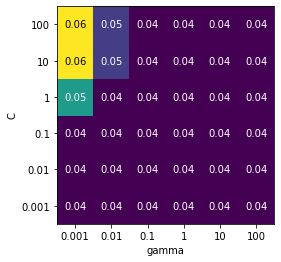

In [868]:
#시각화
import mglearn
scores = results['mean_test_score'].values.reshape(6,6)
print(pd.DataFrame(scores,
                    columns=['gamma1','2','3','4','5','6'],
                    index = ['C1','2','3','4','5','6']))
mglearn.tools.heatmap(scores, xlabel = 'gamma', ylabel='C',
                        xticklabels=param_grid['gamma'],
                        yticklabels=param_grid['C'])                  
plt.show()

#확인 결과 가장 높은 수치가 중간에 있으니 그게 최적화, 더이상 확인할 필요 X
#if, 가장 높은 값이 좌우상하 코너에 걸리는 경우에는 추가 확인 필요 (C, gamma 값 범위 증가 시켜서 확인)

In [869]:
# 위의 모든 과정이 한 세트 -> 그걸 또 여러번 cross_val 반복해야 함
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
gsc = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

scores = cross_val_score(gsc, X, y, cv=5)
print(scores, scores.mean())

KeyboardInterrupt: 

# 예측-실제비교

In [871]:
from sklearn.model_selection import train_test_split
X = df4.iloc[:,3:].values
y = df3['next_year_salary'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(random_state=0, max_depth=8) 
RFR.fit(X_train, y_train)
print("max_depth:{0}".format(RFR.max_depth), RFR.score(X_train, y_train), RFR.score(X_test, y_test))

max_depth:8 0.9889907864970157 0.97929478686125


In [872]:
a = df4

def after(a) :
    return RFR.predict(a.iloc[:,3:].values)

df3['pred_salary'] = after(a)
df3
df3.to_excel('pred3.xlsx')